<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Открытие-и-подготовка-данных" data-toc-modified-id="Открытие-и-подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Открытие и подготовка данных</a></span></li><li><span><a href="#Предобработка" data-toc-modified-id="Предобработка-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Предобработка</a></span></li><li><span><a href="#Основные-данные" data-toc-modified-id="Основные-данные-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Основные данные</a></span><ul class="toc-item"><li><span><a href="#Анонимные-названия-проектов" data-toc-modified-id="Анонимные-названия-проектов-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Анонимные названия проектов</a></span></li></ul></li><li><span><a href="#Детализация" data-toc-modified-id="Детализация-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Детализация</a></span><ul class="toc-item"><li><span><a href="#Анонимные-названия-проектов" data-toc-modified-id="Анонимные-названия-проектов-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Анонимные названия проектов</a></span></li></ul></li><li><span><a href="#База-данных-Postgres" data-toc-modified-id="База-данных-Postgres-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>База данных Postgres</a></span></li><li><span><a href="#Дашборд" data-toc-modified-id="Дашборд-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Дашборд</a></span><ul class="toc-item"><li><span><a href="#Анонимные-данные" data-toc-modified-id="Анонимные-данные-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Анонимные данные</a></span></li></ul></li></ul></div>

## Описание проекта

В данном проекте происходит обработка данных из типовых отчётов по перечню и количеству ошибок по отдельным проектам. После обработки данные выгружаются в файл, на основе которого будет строиться дашборд.

**Основные задачи**:
- подготовить данные для построения дашборда
- построить дашборд

**План работы**:
- загрузка csv-файла из confluence
- трансформация, предобработка данных на Python
- выгрузка файла для построения дашборда
- подготовить дашборд и прикрепить на него ссылку

**Описание данных**:

В проекте используются данные csv-файла из confluence

## Открытие и подготовка данных

Импортируем необходимые библиотеки:

In [1]:
import pandas as pd
import os
from pathlib import Path
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import datetime as dt
from datetime import datetime, date, timedelta

import warnings

Устанавливаем нужные опции:

In [2]:
# чтобы посмотреть текст столбца целиком
pd.set_option('display.max_colwidth', None)

# чтобы посмотреть все столбцы
pd.set_option('display.max_columns', None)

warnings.filterwarnings("ignore")

Открываем файл:

In [3]:
if os.path.exists('/datasets/error_report_confluence_table.csv'):
    data = pd.read_csv('/datasets/error_report_confluence_table.csv',  sep=';', on_bad_lines='skip')
else:
    data = pd.read_csv('/C:/datasets/error_report_confluence_table.csv',  sep=';', on_bad_lines='skip')

Данные загружены, можно приступать к следующему шагу.

## Предобработка

Переворачиваем таблицу, чтобы дату переместить из заголовков в колонку:

In [4]:
data= data.T
data.reset_index(inplace= True)

Удаляем пустой столбец:

In [5]:
data = data.drop(columns=[4])

Наводим порядок с названиями столбцов:

In [6]:
data.columns = list(data.iloc[0])
data.rename(columns={data.columns[0]:'dt'}, inplace=True)                     
data = data.iloc[1:]

Приводим в порядок данные с датами:

In [7]:
data['dt'] = data['dt'].astype(str)
data['dt'] = data['dt'].str[:10]
data['dt'] = pd.to_datetime(data['dt'], format='%d.%m.%Y')

Файл преобразился, но в таком виде с ним ещё неудобно будет работать в дашборде.

## Основные данные

Выделяем основные данные:

In [8]:
main = data[['dt', 'Project', 'Ratio of unique errors to the total','Number of unique errors', 'Total errors number']]

Переименовываем столбцы в стиле snake-case (нижний регистр, пробелы заменяем нижним подчёркиванием):

In [9]:
main.columns = ['dt', 'project', 'ratio_of_unique_errors_to_the_total', 'number_of_unique_errors', 'total_errors_number']

Приводим типы данных:

In [10]:
main['dt'] = main['dt'].dt.date
main['number_of_unique_errors'] = main['number_of_unique_errors'].astype('int')
main['total_errors_number'] = main['total_errors_number'].astype('int')

### Анонимные названия проектов

Добавляем анонимные названия проектов. Для этого выделяем реальные названия проектов:

In [11]:
real_names = sorted(list(main['project'].unique()))

Для такого количества проектов генерируем анонимные имена:

In [12]:
anonymous_names = []

for i in range(len(real_names)):
    a = 'project_'+str(i+1)
    anonymous_names.append(a)

Соединяем их в датафрейм:

In [13]:
real_and_anonymous_names = pd.DataFrame(
    {'project': real_names,
     'project_anonymous': anonymous_names
    })

Присоединяем анонимные имена к основному файлу:

In [14]:
main = pd.merge(main, real_and_anonymous_names, on='project', how='left')

## Детализация

Чтобы на основе этого файла можно было построить хороший дашборд, нам нужно все названия видов ошибок сместить из названий столбцов - в одно поле, и рядом с ним поставить другое поле - с количеством ошибок.

То есть: название типа ошибки(текст) - количество ошибок этого типа(число).

Объём данных сместится из горизонтального положения (много столбцов) - в вертикальное положение (много строк).

In [15]:
# создаём список для будущих детальных датафреймов
details = list()

# для каждой строки сырых данных
for i in range(len(data)):
    
    # вычленяем всю детальную информацию по типам ошибок
    # это данные с 5-го столбца и дальше (нумерация идёт от 0)
    data_details = data.iloc[i][5:]
    
    # записываем её в датафрейм
    df_details = pd.DataFrame(data_details)
    df_details.reset_index(inplace= True)
    
    # вставляем в этот же датафрейм общую информацию
    # то есть данные из столбцов с 0-го по 4-й
    df_details.insert(0, 'dt', data.iloc[i][0])
    df_details.insert(1, 'project', data.iloc[i][1])
    df_details.insert(2, 'ratio_of_unique_errors_to_the_total', data.iloc[i][2])
    df_details.insert(3, 'number_of_unique_errors', data.iloc[i][3])
    df_details.insert(4, 'total_errors_number', data.iloc[i][4])

    # наводим порядок в названиях новых столбцов
    df_details.rename(columns={'index':'error_name', i+1:'error_number'}, inplace=True) 
    
    # добавляем получившийся детализированный датафрейм в заготовленный ранее список
    details.append(df_details)
    
# соединияем детализированные датафреймы
df = pd.concat(details, ignore_index=True)


### Анонимные названия проектов

Добавляем к этому датафрейму также анонимные имена проектов:

In [16]:
df = pd.merge(df, real_and_anonymous_names, on='project', how='left')

В таком виде с данными будет удобно работать.

Перед выгрузкой файла приведём типы данных в нужные форматы:

In [17]:
df['dt'] = df['dt'].dt.date
df['number_of_unique_errors'] = df['number_of_unique_errors'].astype('int')
df['total_errors_number'] = df['total_errors_number'].astype('int')
df['error_number'] = df['error_number'].astype('int')

Также для того,чтобы чтение файла не спотыкалось о значения сепаратора, символ сепаратора заменим на другой символ:

In [18]:
df['error_name'] = df['error_name'].str.replace(';', ',')

## База данных Postgres

Записываем детализированный файл в базу данных:

In [19]:
import psycopg2
from psycopg2 import Error

connection = psycopg2.connect(user = "postgres",
                                  password = "123",
                                  host = "localhost",
                                  port = "5433",
                                  database = "postgres")
cursor = connection.cursor()

# Удаляем таблицу, если она уже есть
drop_table_query = '''drop table if exists report ;'''

# Создаём таблицу, прописываем DLL
create_table_query = '''CREATE TABLE report
(
 dt date NOT NULL,
 project varchar(50) NOT NULL,
 ratio_of_unique_errors_to_the_total numeric NOT NULL,
 number_of_unique_errors Int4 NOT NULL,
 total_errors_number Int4 NOT NULL,
 error_name varchar(500) NULL,
 error_number Int4 NULL
);'''

# Перед вставкой данных удаляем содержимое таблицы на всякий случай
truncate_table_query = '''truncate table report; '''

cursor.execute(drop_table_query)
cursor.execute(create_table_query)
cursor.execute(truncate_table_query)

f = open(r'/datasets/error_report_dashboard_file/error_report_dashboard_file.csv')

# пропускаем заголовки - иначе заголовок становится первой строкой данных и все данные могут быть только текстом
next(f) 

# копируем файл в базу данных
cursor.copy_from(f, 'report', sep=';')

connection.commit()
connection.close()

f.close()

## Дашборд

### Анонимные данные

Себе в портфолио я оставляю вариант с анонимными названиями проектов

In [20]:
main2 = main.drop(columns=['project'])

df2 = df.drop(columns=['project'])

In [21]:
main2.to_csv('/datasets/error_report_dashboard_file/main_dashboard_file_project_anonymous.csv', index=False)

df2.to_csv('/datasets/error_report_dashboard_file/error_report_dashboard_file_project_anonymous.csv', index=False, sep = ';')

В дашборде три вкладки

**основное**

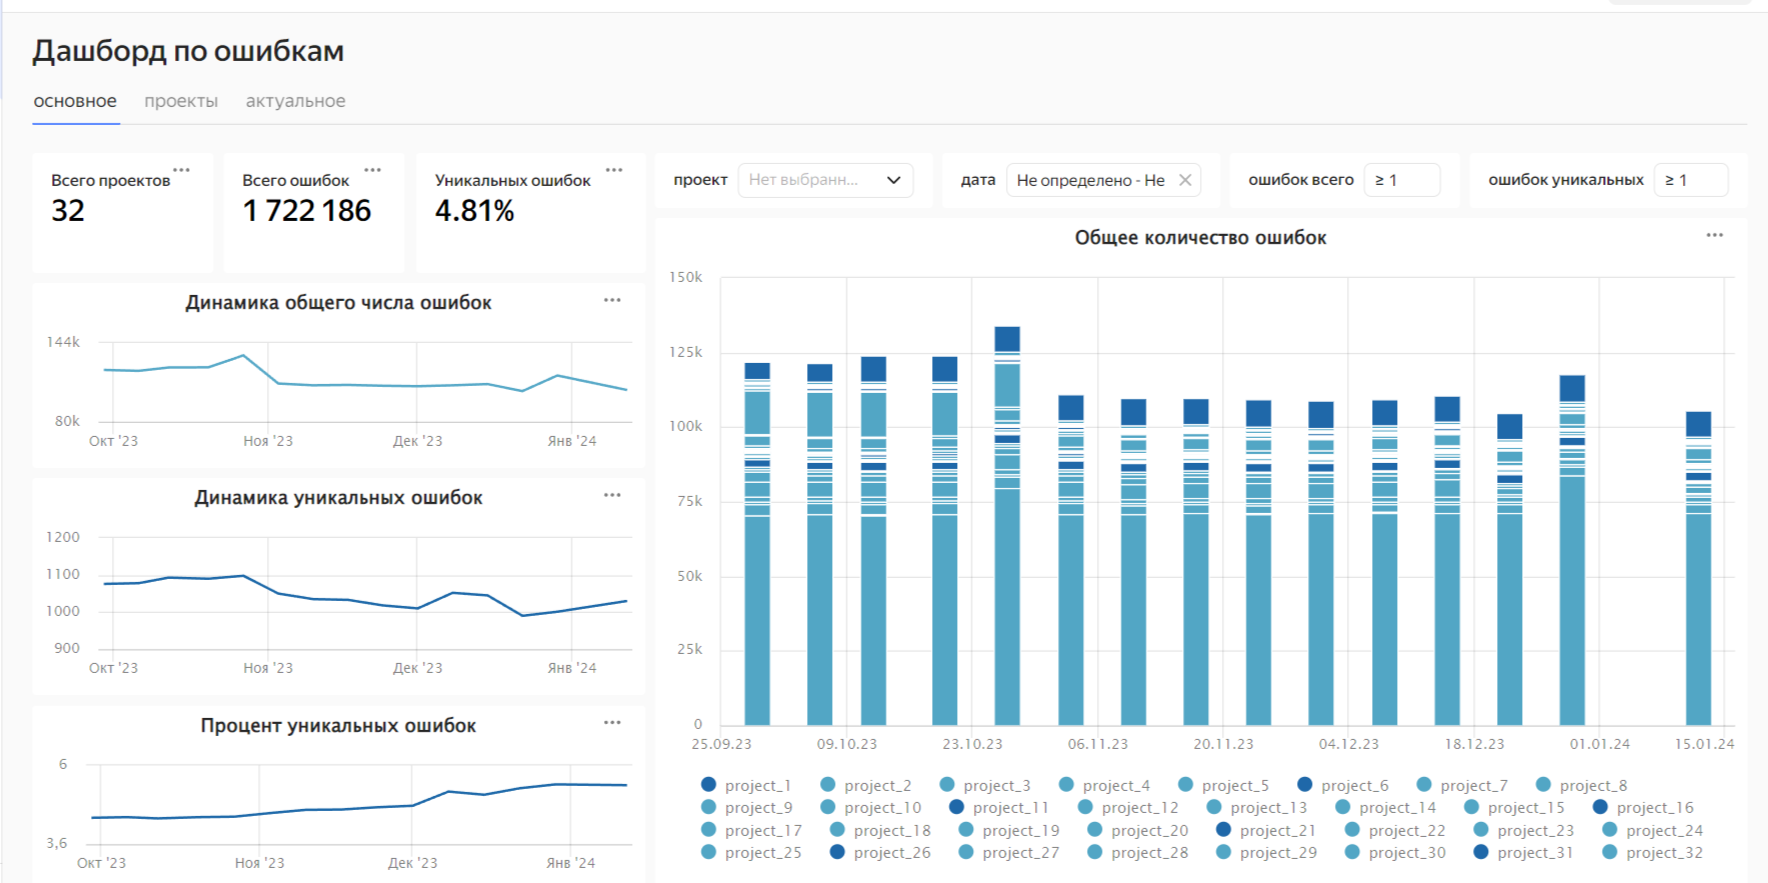

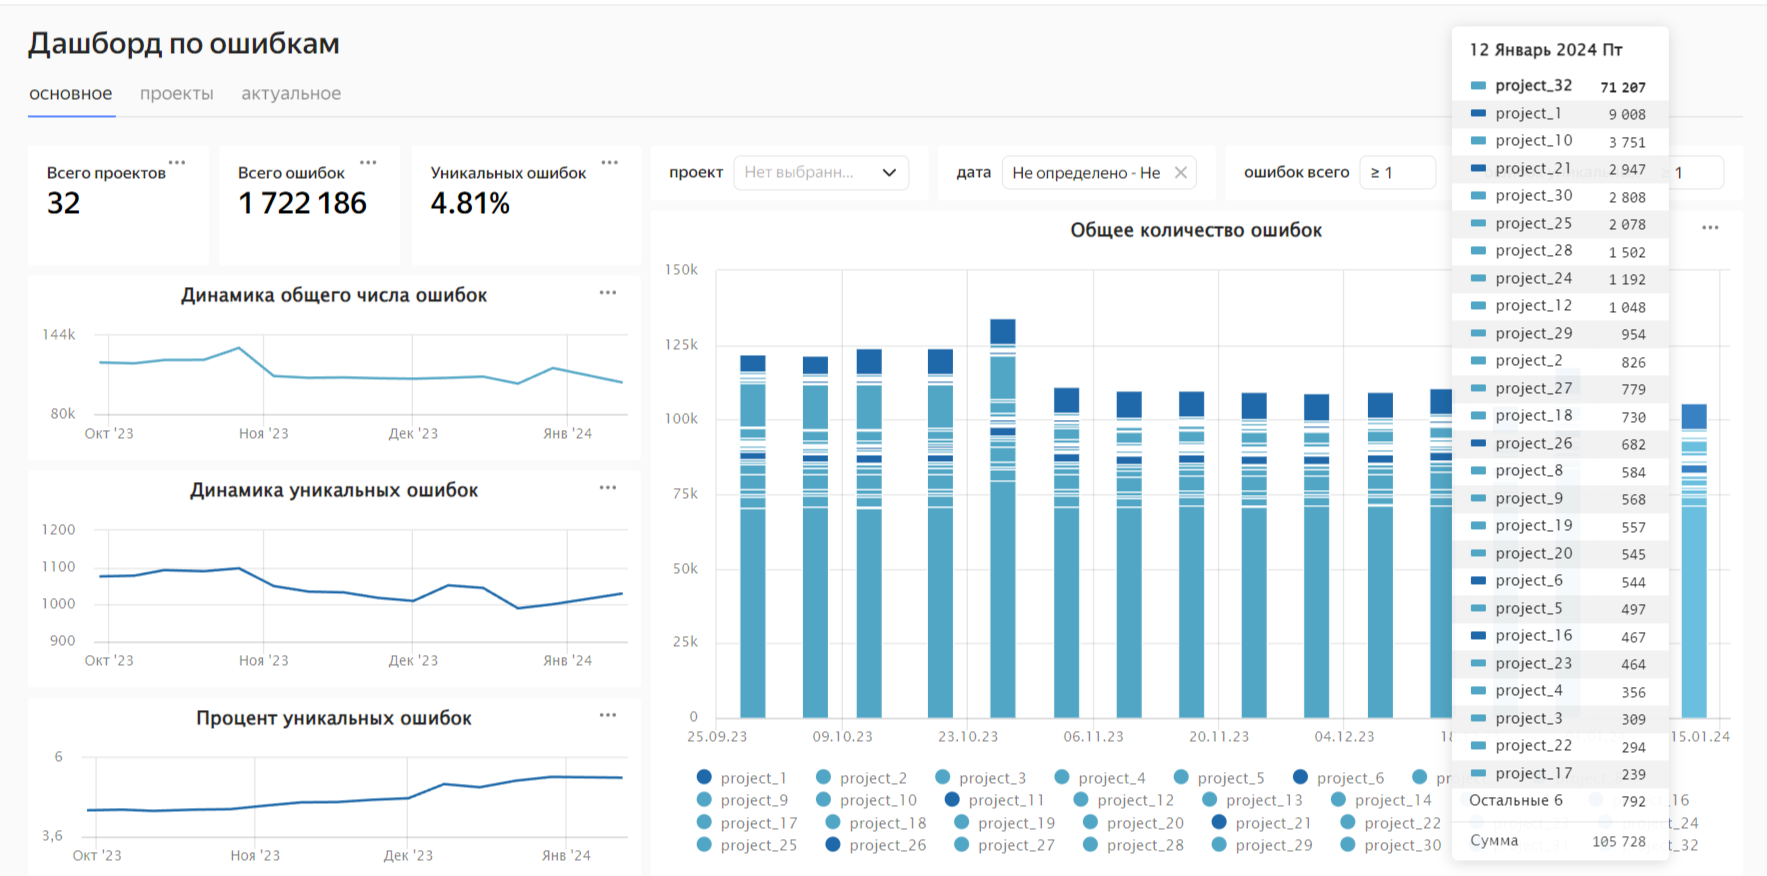

**проекты**

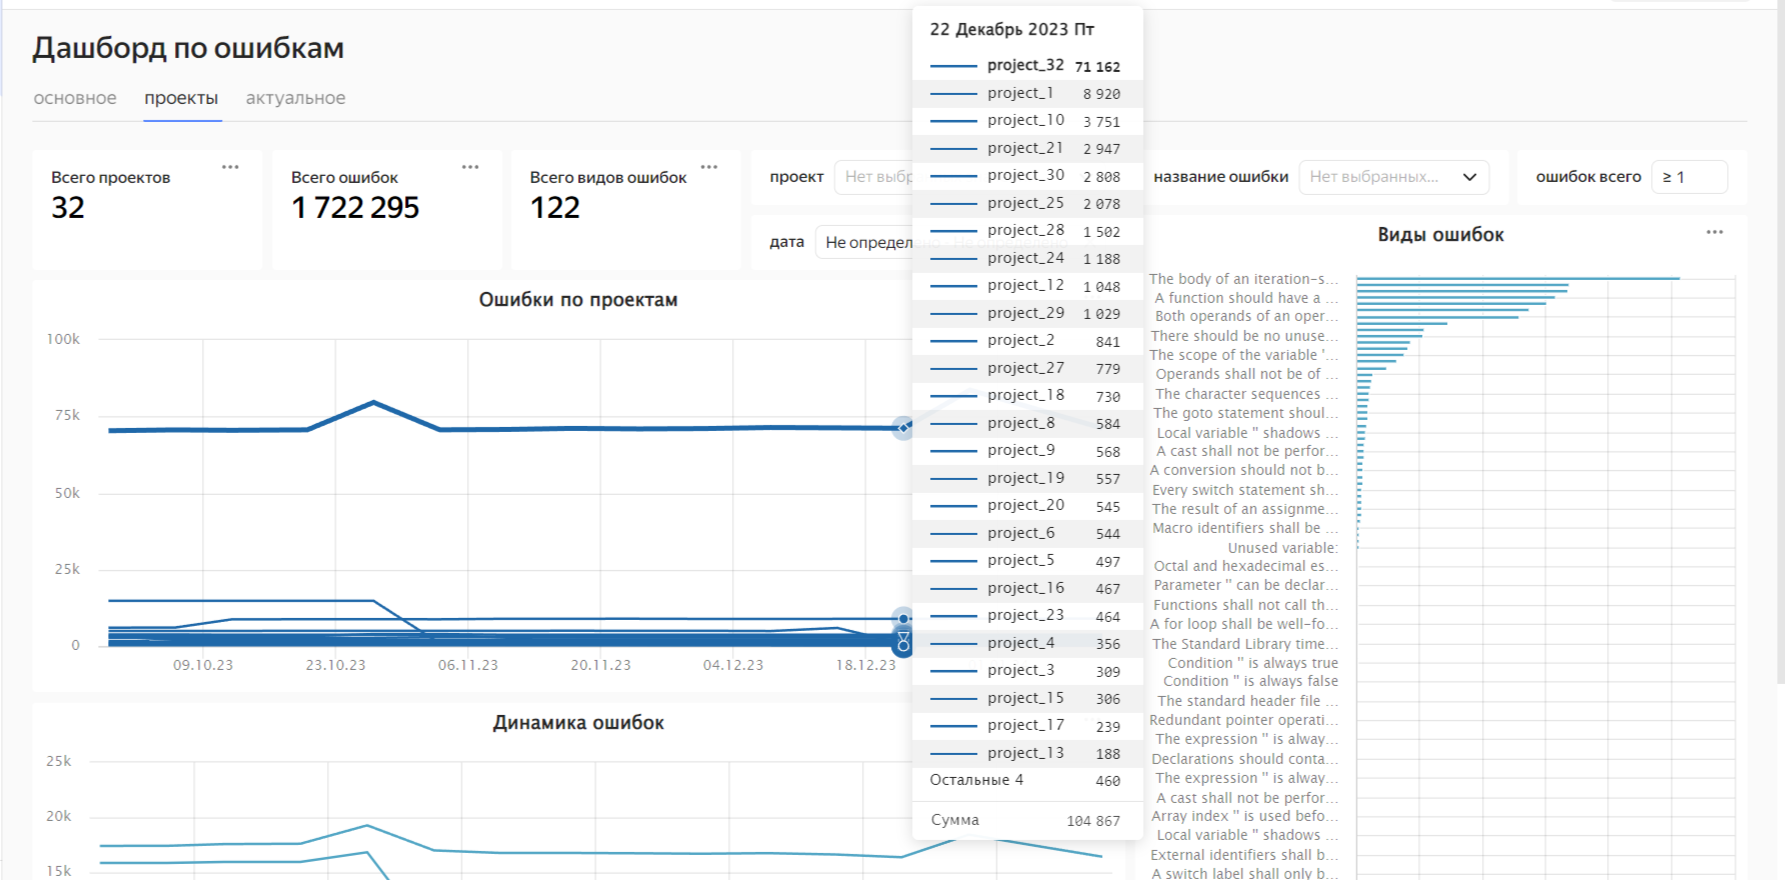

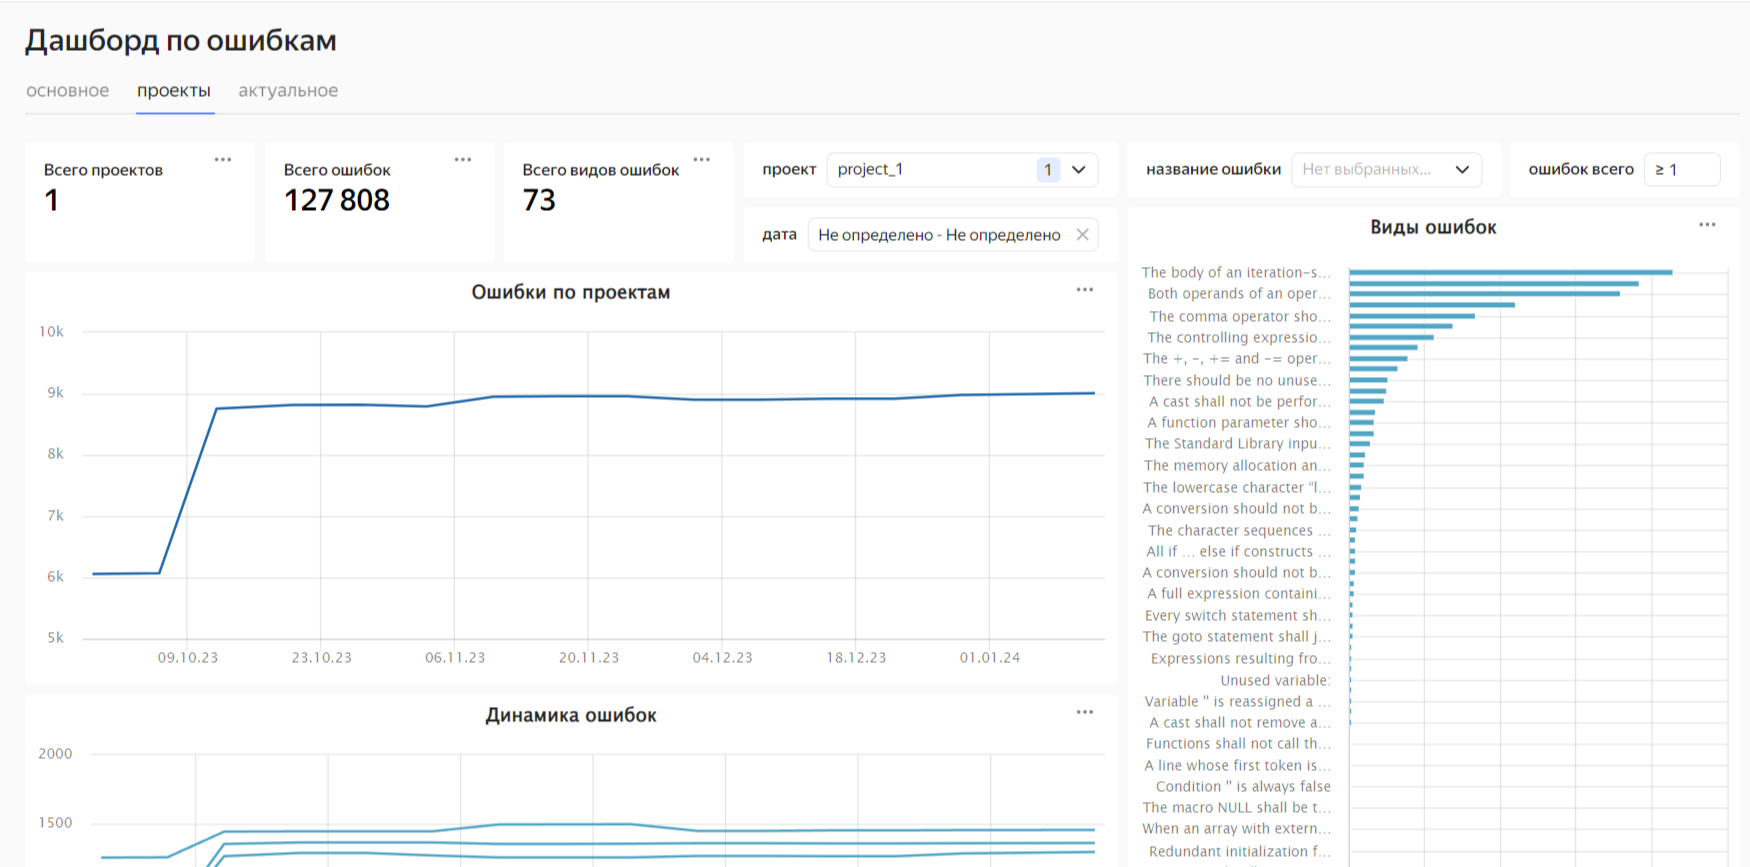

**актуальное**

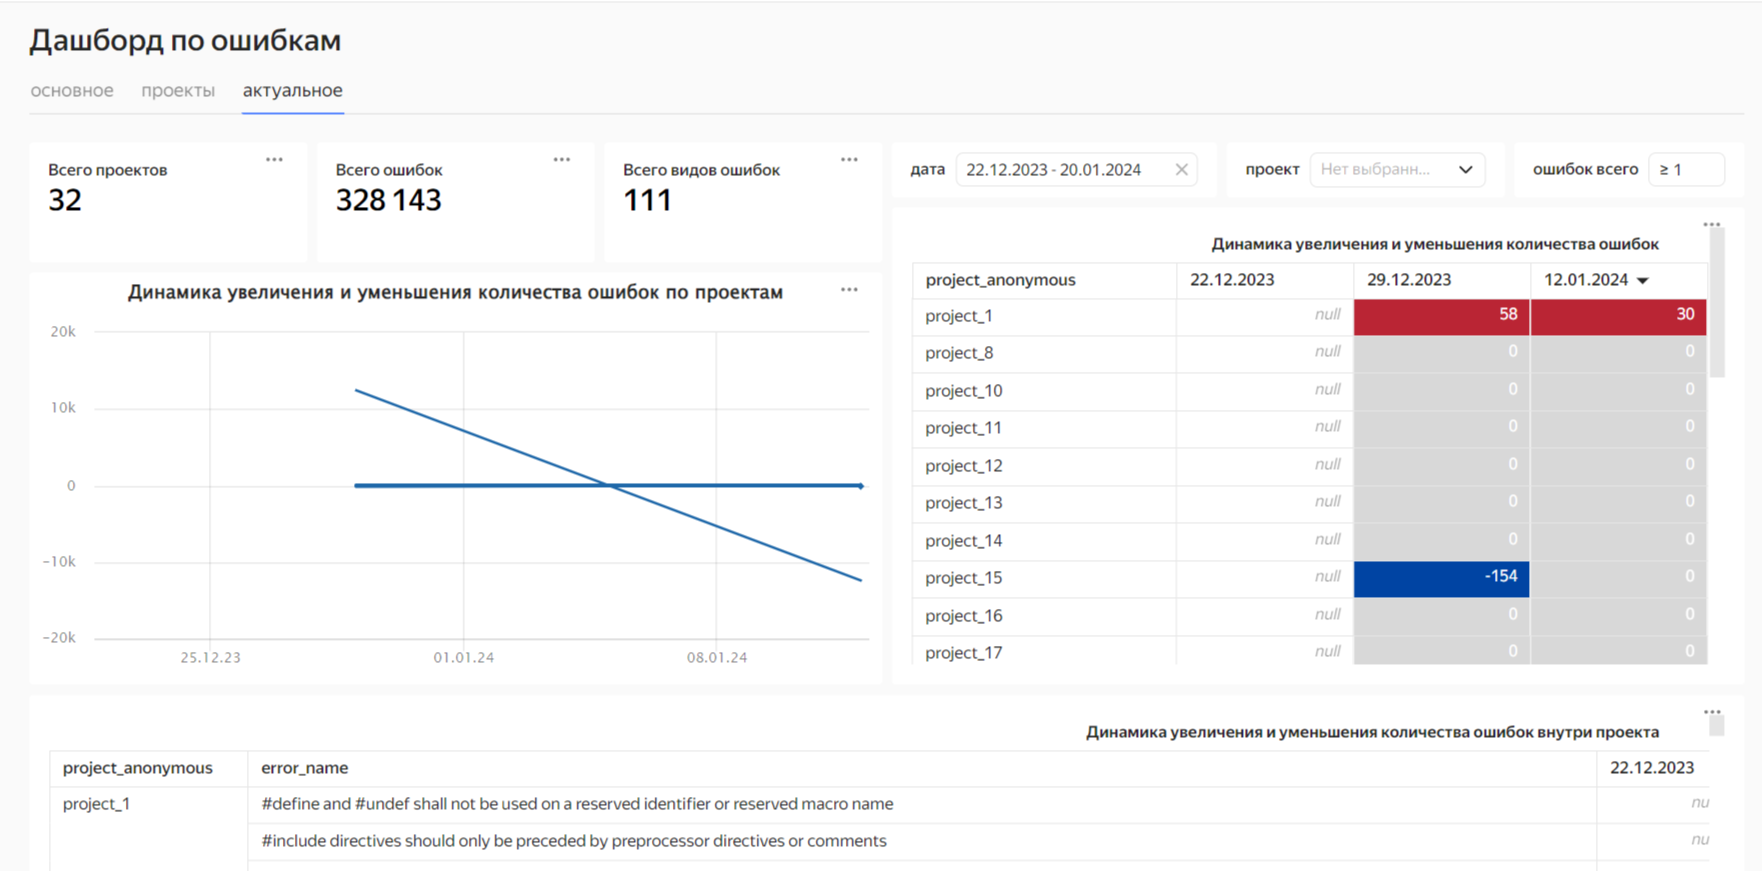

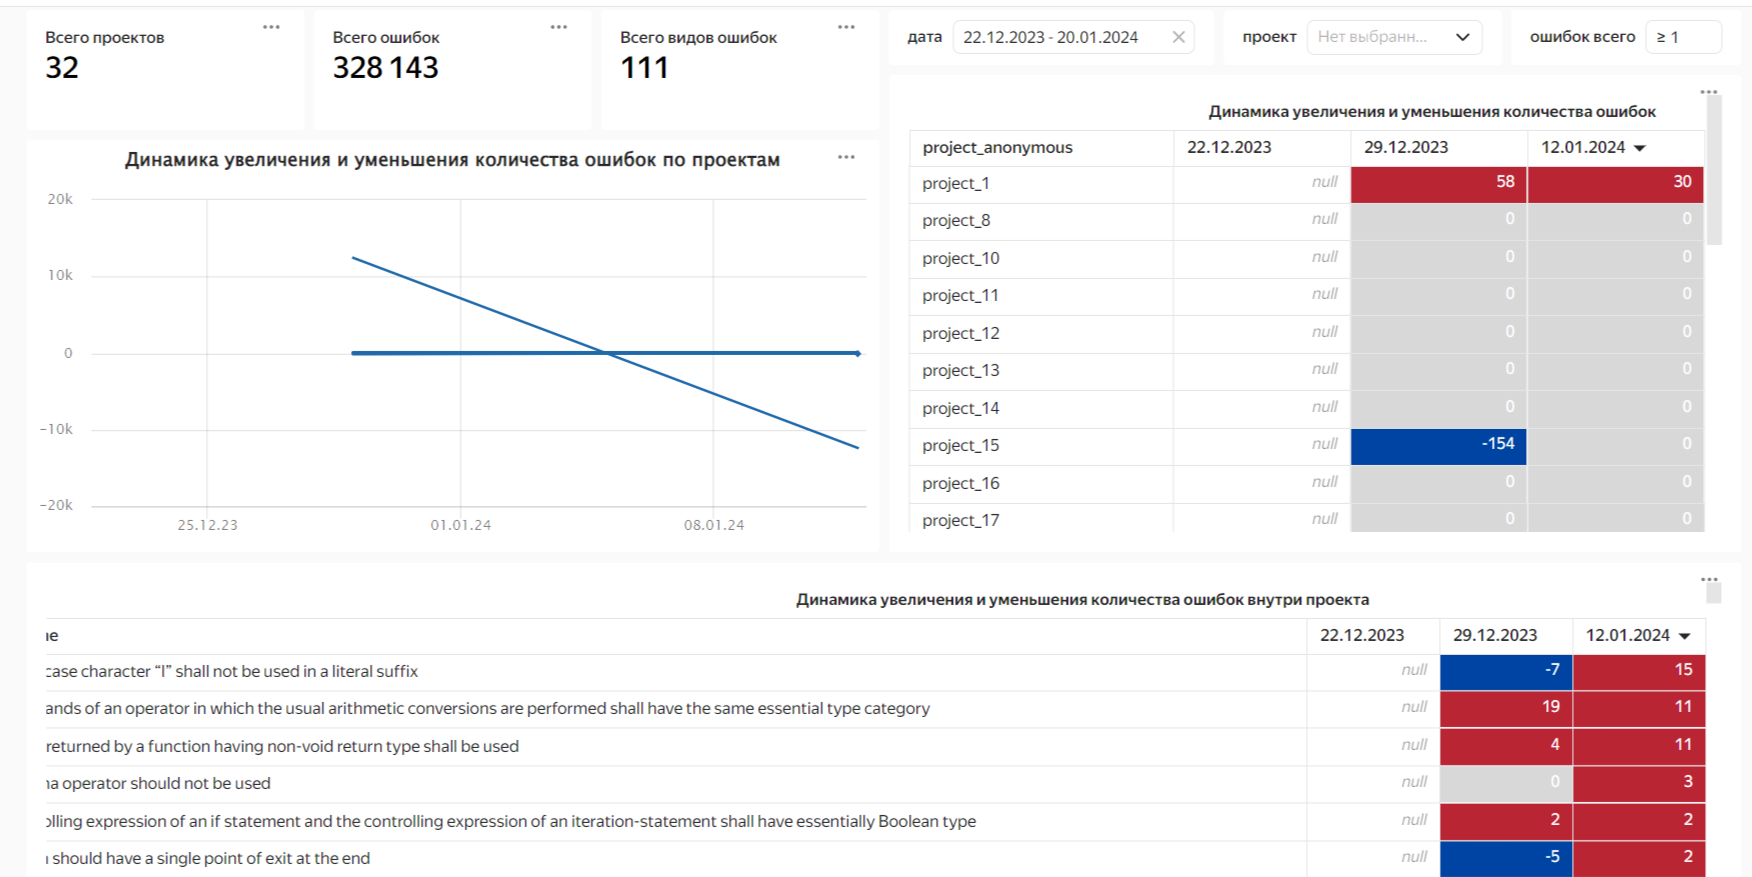


_____________________________________________________________________________________________________________________________
Проект выполнила: аналитик данных Малахова Наталья

Мой телеграм-канал: [Дневник аналитика](https://t.me/diary_musician_analyst "Дневник аналитика")

Портфолио: [GitHub](https://github.com/Malakhova-Natalya "GitHub")



Спасибо за внимание!